# KPI & COHORT ANALYSIS : RETENTION RATE

In [44]:
# RETENTION RATE KPI in the COHORT ANALYSIS in 3 STEPS

# 1. Brief Data Preprocessing
# 2. Creating the Retention Matrix
#    1. Calculate the unique number of orders for each customer
#    2. Percentage of customers ordering more than once across the entire dataset.
#    3. Finding out the order months.
#    4. Creating the cohort variable
#    5. Finding out the number of monthly customers.
#    6. Finding out the period number
#    7. Creating the Cohort_pivot
#    8. Creating the retention matrix
# 3. Visuzalizing the Retention Matrix with heatmap

In [30]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

data = pd.read_excel("C:\\Users\\Emre\\Desktop\\DSMLBC Bootcamp\\Datasets\\online_retail.xlsx",
                   dtype={'CustomerID': str,
                          'InvoiceID': str},
                   parse_dates=['InvoiceDate'])

df = data.copy()
df.head()

InvoiceNo StockCode                     Description  Quantity  \
0    581587     22631        CIRCUS PARADE LUNCH BOX         12   
1    581587     22556  PLASTERS IN TIN CIRCUS PARADE         12   
2    581587     22555       PLASTERS IN TIN STRONGMAN        12   
3    581587     22728       ALARM CLOCK BAKELIKE PINK         4   
4    581587     22727       ALARM CLOCK BAKELIKE RED          4   

          InvoiceDate  UnitPrice CustomerID Country  
0 2011-12-09 12:50:00       1.95      12680  France  
1 2011-12-09 12:50:00       1.65      12680  France  
2 2011-12-09 12:50:00       1.65      12680  France  
3 2011-12-09 12:50:00       3.75      12680  France  
4 2011-12-09 12:50:00       3.75      12680  France

In [3]:
df.columns
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [31]:
# removing null values in CustomerID & drop duplicates in 'CustomerID', 'InvoiceNo', 'InvoiceDate'
# Since I am only interested in purchasing by customers in certain periods. I'll implement retention rate accordingly. I dropped to avoid multiplex data in related columns.

df.dropna(subset=['CustomerID'], inplace=True)
df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

In [32]:
df.shape

(22221, 3)

In [33]:
#2.1 Calculate the unique number of orders for each customer
n_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()
n_orders

CustomerID
12346     2
12347     7
12348     4
12349     1
12350     1
         ..
18280     1
18281     1
18282     3
18283    16
18287     3
Name: InvoiceNo, Length: 4372, dtype: int64

In [34]:
# 2.2 Percentage of customers ordering more than once across the entire dataset.
orders_perc = np.sum(n_orders > 1) / df['CustomerID'].nunique()
orders_perc * 100 

69.967978042086

In [35]:
# 2.3 Finding out the order months.
df['order_month'] = df['InvoiceDate'].dt.to_period('M')          # datetime module, "M" refers to month!
df['order_month']

0         2011-12
15        2011-12
19        2011-12
40        2011-12
42        2011-12
           ...   
541883    2010-12
541884    2010-12
541896    2010-12
541900    2010-12
541902    2010-12
Name: order_month, Length: 22221, dtype: period[M]

In [36]:
# 2.4 Creating the cohort variable
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df

CustomerID InvoiceNo         InvoiceDate order_month   cohort
0           12680    581587 2011-12-09 12:50:00     2011-12  2011-08
15          13113    581586 2011-12-09 12:49:00     2011-12  2010-12
19          15804    581585 2011-12-09 12:31:00     2011-12  2011-05
40          13777    581584 2011-12-09 12:25:00     2011-12  2010-12
42          13777    581583 2011-12-09 12:23:00     2011-12  2010-12
...           ...       ...                 ...         ...      ...
541883      13047    536369 2010-12-01 08:35:00     2010-12  2010-12
541884      13047    536367 2010-12-01 08:34:00     2010-12  2010-12
541896      13047    536368 2010-12-01 08:34:00     2010-12  2010-12
541900      17850    536366 2010-12-01 08:28:00     2010-12  2010-12
541902      17850    536365 2010-12-01 08:26:00     2010-12  2010-12

[22221 rows x 5 columns]

In [37]:
# 2.5 Finding out the number of monthly customers.
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
df_cohort

cohort order_month  n_customers
0   2010-12     2010-12          948
1   2010-12     2011-01          362
2   2010-12     2011-02          317
3   2010-12     2011-03          367
4   2010-12     2011-04          341
..      ...         ...          ...
86  2011-10     2011-11           93
87  2011-10     2011-12           46
88  2011-11     2011-11          321
89  2011-11     2011-12           43
90  2011-12     2011-12           41

[91 rows x 3 columns]

In [39]:
# 2.6 Finding out the period number
(df_cohort.order_month - df_cohort.cohort).head()

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort

cohort order_month  n_customers  period_number
0   2010-12     2010-12          948              0
1   2010-12     2011-01          362              1
2   2010-12     2011-02          317              2
3   2010-12     2011-03          367              3
4   2010-12     2011-04          341              4
..      ...         ...          ...            ...
86  2011-10     2011-11           93              1
87  2011-10     2011-12           46              2
88  2011-11     2011-11          321              0
89  2011-11     2011-12           43              1
90  2011-12     2011-12           41              0

[91 rows x 4 columns]

In [40]:
# 2.7. Creating the Cohort_pivot
cohort_pivot = df_cohort.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='n_customers')

cohort_size = cohort_pivot.iloc[:, 0]
cohort_pivot

period_number     0      1      2      3      4      5      6      7      8   \
cohort                                                                         
2010-12        948.0  362.0  317.0  367.0  341.0  376.0  360.0  336.0  336.0   
2011-01        421.0  101.0  119.0  102.0  138.0  126.0  110.0  108.0  131.0   
2011-02        380.0   94.0   73.0  106.0  102.0   94.0   97.0  107.0   98.0   
2011-03        440.0   84.0  112.0   96.0  102.0   78.0  116.0  105.0  127.0   
2011-04        299.0   68.0   66.0   63.0   62.0   71.0   69.0   78.0   25.0   
...              ...    ...    ...    ...    ...    ...    ...    ...    ...   
2011-08        167.0   42.0   42.0   42.0   23.0    NaN    NaN    NaN    NaN   
2011-09        298.0   89.0   97.0   36.0    NaN    NaN    NaN    NaN    NaN   
2011-10        352.0   93.0   46.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11        321.0   43.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12         41.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

period_number     9      10     11     12  
cohort                                     
2010-12        374.0  354.0  474.0  260.0  
2011-01        146.0  155.0   63.0    NaN  
2011-02        119.0   35.0    NaN    NaN  
2011-03         39.0    NaN    NaN    NaN  
2011-04          NaN    NaN    NaN    NaN  
...              ...    ...    ...    ...  
2011-08          NaN    NaN    NaN    NaN  
2011-09          NaN    NaN    NaN    NaN  
2011-10          NaN    NaN    NaN    NaN  
2011-11          NaN    NaN    NaN    NaN  
2011-12          NaN    NaN    NaN    NaN  

[13 rows x 13 columns]

In [41]:
# 2.8. Creating the retention matrix
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix

period_number   0         1         2         3         4         5   \
cohort                                                                 
2010-12        1.0  0.381857  0.334388  0.387131  0.359705  0.396624   
2011-01        1.0  0.239905  0.282660  0.242280  0.327791  0.299287   
2011-02        1.0  0.247368  0.192105  0.278947  0.268421  0.247368   
2011-03        1.0  0.190909  0.254545  0.218182  0.231818  0.177273   
2011-04        1.0  0.227425  0.220736  0.210702  0.207358  0.237458   
...            ...       ...       ...       ...       ...       ...   
2011-08        1.0  0.251497  0.251497  0.251497  0.137725       NaN   
2011-09        1.0  0.298658  0.325503  0.120805       NaN       NaN   
2011-10        1.0  0.264205  0.130682       NaN       NaN       NaN   
2011-11        1.0  0.133956       NaN       NaN       NaN       NaN   
2011-12        1.0       NaN       NaN       NaN       NaN       NaN   

period_number        6         7         8         9         10        11  \
cohort                                                                      
2010-12        0.379747  0.354430  0.354430  0.394515  0.373418  0.500000   
2011-01        0.261283  0.256532  0.311164  0.346793  0.368171  0.149644   
2011-02        0.255263  0.281579  0.257895  0.313158  0.092105       NaN   
2011-03        0.263636  0.238636  0.288636  0.088636       NaN       NaN   
2011-04        0.230769  0.260870  0.083612       NaN       NaN       NaN   
...                 ...       ...       ...       ...       ...       ...   
2011-08             NaN       NaN       NaN       NaN       NaN       NaN   
2011-09             NaN       NaN       NaN       NaN       NaN       NaN   
2011-10             NaN       NaN       NaN       NaN       NaN       NaN   
2011-11             NaN       NaN       NaN       NaN       NaN       NaN   
2011-12             NaN       NaN       NaN       NaN       NaN       NaN   

period_number        12  
cohort                   
2010-12        0.274262  
2011-01             NaN  
2011-02             NaN  
2011-03             NaN  
2011-04             NaN  
...                 ...  
2011-08             NaN  
2011-09             NaN  
2011-10             NaN  
2011-11             NaN  
2011-12             NaN  

[13 rows x 13 columns]

In [26]:
# all in one function

def create_retention_matrix(dataframe):
    n_orders = dataframe.groupby(['CustomerID'])['InvoiceNo'].nunique()
    dataframe['order_month'] = dataframe['InvoiceDate'].dt.to_period('M')
    dataframe['cohort'] = dataframe.groupby('CustomerID')['InvoiceDate'] \
        .transform('min') \
        .dt.to_period('M')
    df_cohort = dataframe.groupby(['cohort', 'order_month']) \
        .agg(n_customers=('CustomerID', 'nunique')) \
        .reset_index(drop=False)
    df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
    cohort_pivot = df_cohort.pivot_table(index='cohort',
                                         columns='period_number',
                                         values='n_customers')

    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    return retention_matrix


create_retention_matrix(df)

period_number   0         1         2         3         4         5   \
cohort                                                                 
2010-12        1.0  0.381857  0.334388  0.387131  0.359705  0.396624   
2011-01        1.0  0.239905  0.282660  0.242280  0.327791  0.299287   
2011-02        1.0  0.247368  0.192105  0.278947  0.268421  0.247368   
2011-03        1.0  0.190909  0.254545  0.218182  0.231818  0.177273   
2011-04        1.0  0.227425  0.220736  0.210702  0.207358  0.237458   
...            ...       ...       ...       ...       ...       ...   
2011-08        1.0  0.251497  0.251497  0.251497  0.137725       NaN   
2011-09        1.0  0.298658  0.325503  0.120805       NaN       NaN   
2011-10        1.0  0.264205  0.130682       NaN       NaN       NaN   
2011-11        1.0  0.133956       NaN       NaN       NaN       NaN   
2011-12        1.0       NaN       NaN       NaN       NaN       NaN   

period_number        6         7         8         9         10        11  \
cohort                                                                      
2010-12        0.379747  0.354430  0.354430  0.394515  0.373418  0.500000   
2011-01        0.261283  0.256532  0.311164  0.346793  0.368171  0.149644   
2011-02        0.255263  0.281579  0.257895  0.313158  0.092105       NaN   
2011-03        0.263636  0.238636  0.288636  0.088636       NaN       NaN   
2011-04        0.230769  0.260870  0.083612       NaN       NaN       NaN   
...                 ...       ...       ...       ...       ...       ...   
2011-08             NaN       NaN       NaN       NaN       NaN       NaN   
2011-09             NaN       NaN       NaN       NaN       NaN       NaN   
2011-10             NaN       NaN       NaN       NaN       NaN       NaN   
2011-11             NaN       NaN       NaN       NaN       NaN       NaN   
2011-12             NaN       NaN       NaN       NaN       NaN       NaN   

period_number        12  
cohort                   
2010-12        0.274262  
2011-01             NaN  
2011-02             NaN  
2011-03             NaN  
2011-04             NaN  
...                 ...  
2011-08             NaN  
2011-09             NaN  
2011-10             NaN  
2011-11             NaN  
2011-12             NaN  

[13 rows x 13 columns]

In [43]:
# 3. Visuzalizing the Retention Matrix with heatmap

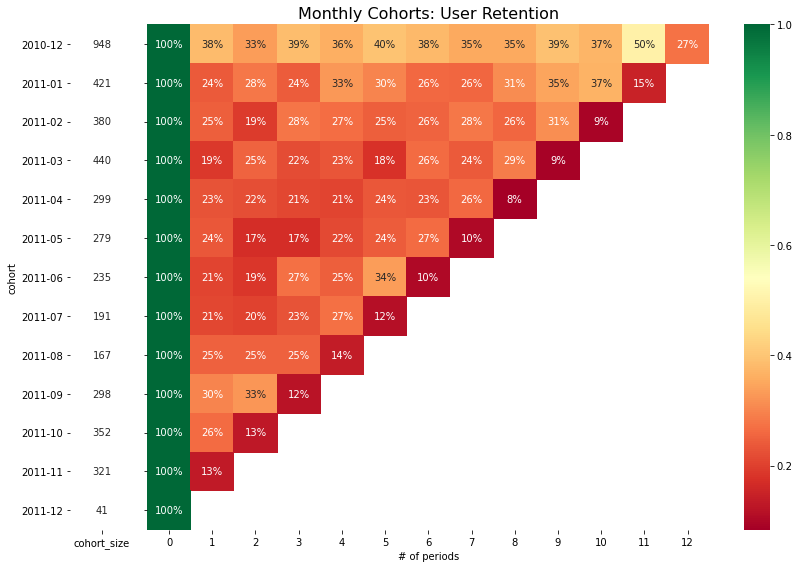

In [28]:
sns.axes_style("white")
fig, ax = plt.subplots(1, 2,
                       figsize=(12, 8),
                       sharey=True,  # y axis
                       gridspec_kw={'width_ratios': [1, 11]}
                       # to create the grid the subplots are placed on
                       )

# retention matrix
sns.heatmap(retention_matrix,
            annot=True,
            fmt='.0%',  # percentage
            cmap='RdYlGn',  # colormap
            ax=ax[1])  

ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
ax[1].set(xlabel='# of periods', ylabel='')

# cohort size
cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
white_cmap = mcolors.ListedColormap(['white'])
sns.heatmap(cohort_size_df,
            annot=True,
            cbar=False,  
            fmt='g',
            cmap=white_cmap,
            ax=ax[0])
fig.tight_layout()
plt.show()